# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score

## Getting the data ready

In [2]:
data_train = pd.read_csv('../data/3_final_data/split_data/logP_wo_parameters_train.csv', index_col=0)
data_valid = pd.read_csv('../data/3_final_data/split_data/logP_wo_parameters_validation.csv', index_col=0)
data_test = pd.read_csv('../data/3_final_data/split_data/logP_wo_parameters_test.csv', index_col=0)

In [3]:
y_train = data_train.logP
y_valid = data_valid.logP
y_test = data_test.logP

In [4]:
X_train_mol = [Chem.MolFromSmiles(x) for x in data_train.smiles]
X_valid_mol = [Chem.MolFromSmiles(x) for x in data_valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in data_test.smiles]

## Building the model

In [5]:
def get_morgan_count_fps(data, bits=2048, radius=2):
    X = [AllChem.GetHashedMorganFingerprint(m, radius, nBits=bits) for m in data]
    X_list = []
    for x in X:
        array = np.zeros((0,), dtype=np.int64)
        DataStructs.ConvertToNumpyArray(x, array)
        X_list.append(array)
    X = pd.DataFrame(X_list)
    return X

In [6]:
X_train = get_morgan_count_fps(X_train_mol, 2048, 2)
X_test = get_morgan_count_fps(X_test_mol, 2048, 2)
regr = MLPRegressor(random_state=10, early_stopping=True).fit(X_train, y_train)
y_predicted = regr.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(rmse)

0.5855120888337747


In [7]:
regr.coefs_[1].shape

(100, 1)

## Getting the data to compare

In [8]:
compare_data = pd.DataFrame({'smiles': data_test.smiles, 'y_expected': y_test, 'y_predicted': y_predicted})

In [9]:
compare_data.head()

,smiles,y_expected,y_predicted
0,Cc1ccccc1C(C)C,4.38,3.712050
1,Clc1nc(-c2ccccc2)nc2ccccc12,4.47,3.936477
2,Cc1ccc(O)c(C(=O)O)c1,2.78,2.391823
3,O=c1[nH]c(O)c(-c2ccccc2)[nH]1,0.46,0.728278
4,CN(C)CCN1c2ccccc2Sc2ccccc21,4.20,4.179734


In [10]:
compare_data.shape

(1894, 3)

In [11]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [12]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,14.621465,175.866454
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.722881,24.234753
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,9.720734,17.814596
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.317653,13.451680
1087,CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1,5.50,2.964316,6.429692


In [13]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
768,CCCCC(C)(C)c1ccc(C2CCCC(O)C2)c(O)c1,5.43,5.430184,3.370080e-08
107,C1CCOC1,0.46,0.460265,7.017615e-08
811,CCOC(CP(=O)(OCC)OCC)OCC,0.69,0.689519,2.310887e-07
1249,C=COCCn1cnc2[nH]c(=O)n(C)c(=N)c21,-0.78,-0.779291,5.022452e-07
1743,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,4.59,4.589188,6.586371e-07


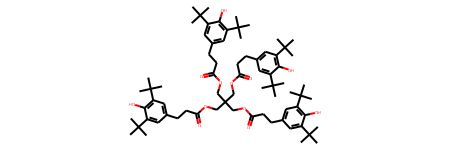

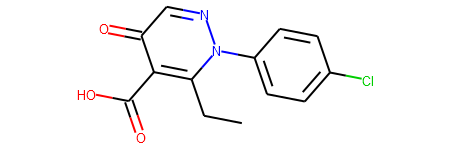

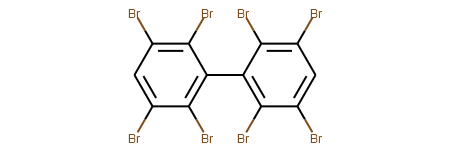

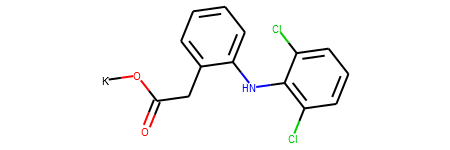

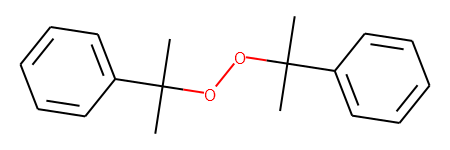

In [14]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

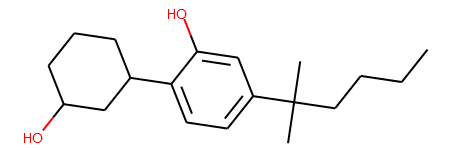

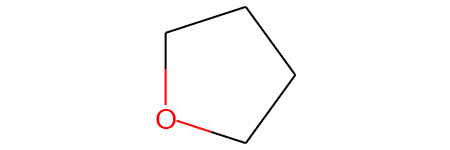

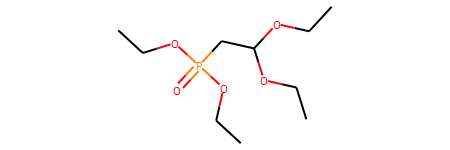

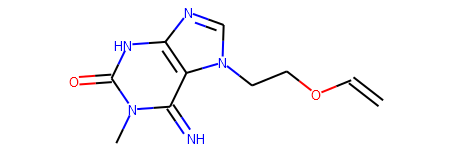

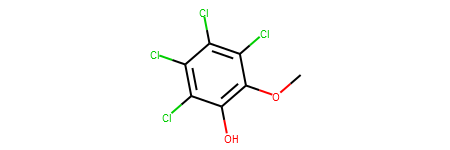

In [15]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [16]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings

In [17]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    return values

## Analyzing the data features

In [18]:
compare_data_with_stats = create_statistics(compare_data)

In [19]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
768,CCCCC(C)(C)c1ccc(C2CCCC(O)C2)c(O)c1,5.43,5.430184,3.370080e-08,7,0,1,14.285714,0,0.0
107,C1CCOC1,0.46,0.460265,7.017615e-08,16,1,3,18.750000,1,100.0
811,CCOC(CP(=O)(OCC)OCC)OCC,0.69,0.689519,2.310887e-07,14,1,0,0.000000,1,100.0
1249,C=COCCn1cnc2[nH]c(=O)n(C)c(=N)c21,-0.78,-0.779291,5.022452e-07,12,1,0,0.000000,0,0.0
1743,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,4.59,4.589188,6.586371e-07,13,1,3,23.076923,1,100.0


#### Splitting data into 3 parts

In [40]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [41]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,1.987282,1.981770,6.770970e-03,16.610143,1.687797,0.852615,5.464131,0.868463,53.192023
std,1.794482,1.792532,6.180035e-03,7.291884,1.062713,1.311302,8.584575,0.723837,42.584531
min,-3.640000,-3.665327,3.370080e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.825000,0.797865,1.119281e-03,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.830000,1.824830,4.899931e-03,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000
75%,2.905000,2.857523,1.196606e-02,20.000000,2.000000,1.000000,8.333333,1.000000,100.000000
max,8.200000,8.276035,2.067379e-02,85.000000,8.000000,9.000000,60.000000,4.000000,100.000000


In [42]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.032409,2.032897,0.063292,16.256735,1.657686,0.870048,5.801094,0.862124,50.380349
std,1.734751,1.719883,0.032741,6.956373,1.151989,1.341253,9.636508,0.807706,42.654282
min,-3.890000,-3.602515,0.020747,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.825000,0.906079,0.035937,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.870000,1.916341,0.055563,15.000000,1.000000,0.000000,0.000000,1.000000,50.000000
75%,3.085000,3.011359,0.086722,19.000000,2.000000,1.000000,7.692308,1.000000,100.000000
max,7.800000,7.675966,0.137536,59.000000,8.000000,9.000000,80.000000,6.000000,100.000000


In [43]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.093039,2.099048,0.957436,16.568038,1.689873,0.895570,5.793160,0.887658,53.786920
std,1.910699,1.886895,7.113458,6.848493,1.076485,1.372764,8.921015,0.779109,42.896698
min,-3.210000,-2.352085,0.137950,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.735000,0.807866,0.211801,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.910000,1.928587,0.348241,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000
75%,3.422500,3.192836,0.695942,20.000000,2.000000,1.000000,10.000000,1.000000,100.000000
max,9.050000,14.621465,175.866454,58.000000,8.000000,9.000000,71.428571,5.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [83]:
best = data[0].reset_index().drop(columns=['index'])

In [84]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
0,CCCCC(C)(C)c1ccc(C2CCCC(O)C2)c(O)c1,5.43,5.430184,3.370080e-08,7,0,1,14.285714,0,0.0
1,C1CCOC1,0.46,0.460265,7.017615e-08,16,1,3,18.750000,1,100.0
2,CCOC(CP(=O)(OCC)OCC)OCC,0.69,0.689519,2.310887e-07,14,1,0,0.000000,1,100.0
3,C=COCCn1cnc2[nH]c(=O)n(C)c(=N)c21,-0.78,-0.779291,5.022452e-07,12,1,0,0.000000,0,0.0
4,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,4.59,4.589188,6.586371e-07,13,1,3,23.076923,1,100.0


In [85]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

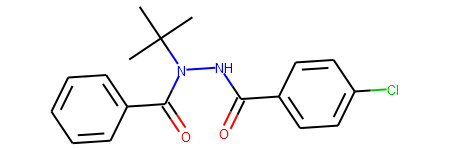

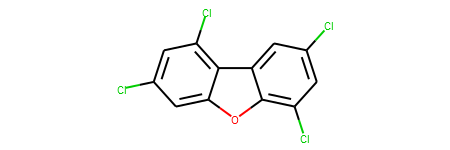

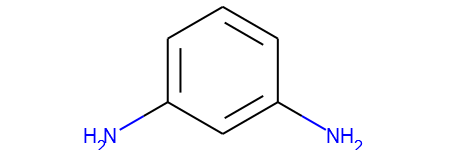

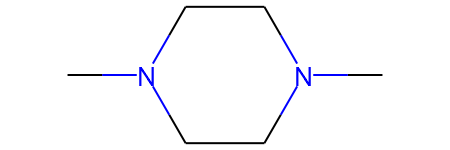

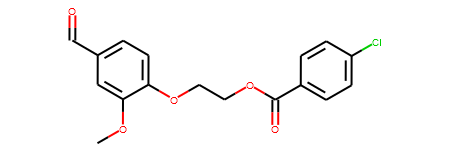

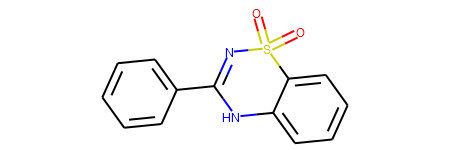

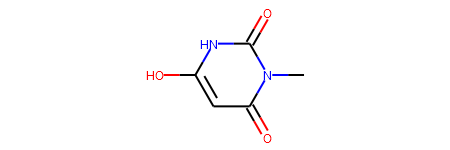

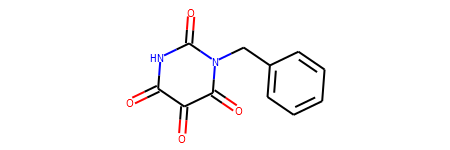

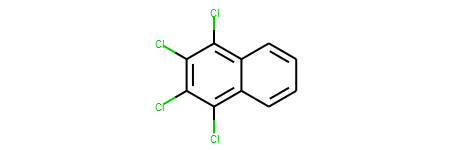

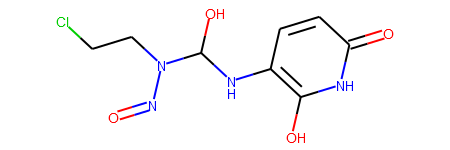

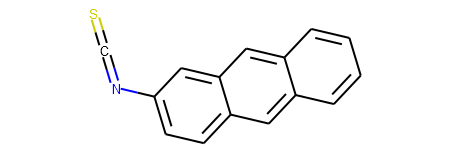

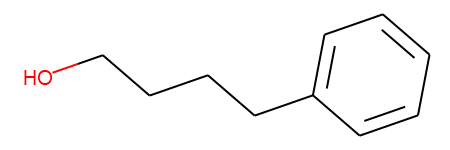

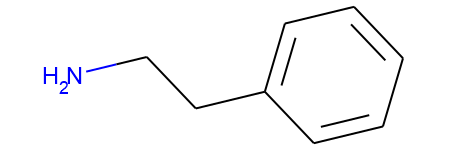

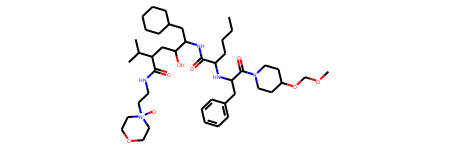

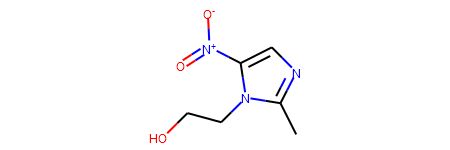

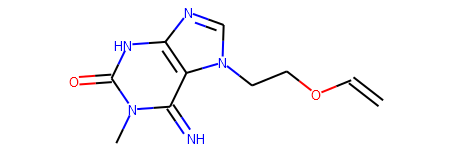

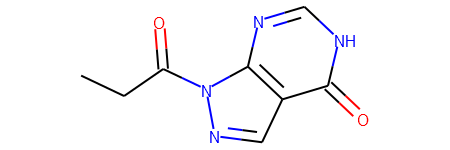

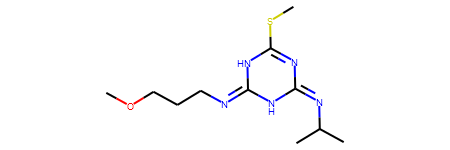

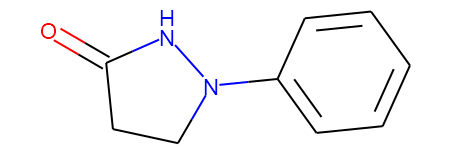

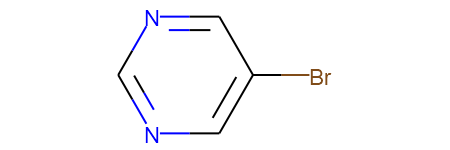

In [86]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [87]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [88]:
middle = data[1].reset_index().drop(columns=['index'])

In [89]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
0,CCCCCCCCC(C)=O,3.73,3.585963,0.020747,16,1,1,6.250000,0,0.0
1,CCN(CCO)Cc1cccc(COc2ccccc2)c1,3.04,3.184309,0.020825,5,0,4,80.000000,0,0.0
2,O=C(O)c1c(Cl)cccc1[N+](=O)[O-],1.56,1.704319,0.020828,15,2,0,0.000000,2,100.0
3,CC1CC2C3CC(F)=C4CC(=O)C(Cl)=CC4(C)C3(F)C(O)CC2...,2.58,2.435395,0.020911,14,1,2,14.285714,0,0.0
4,CCCCCCC(=O)N1CCCC1=O,3.04,2.895225,0.020960,12,1,5,41.666667,0,0.0


In [90]:
middle.shape

(631, 10)

In [91]:
indices = pd.Series(np.random.randint(631, size=20))

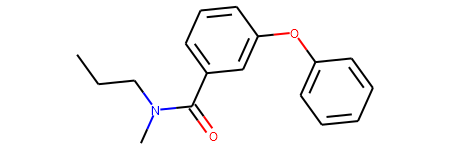

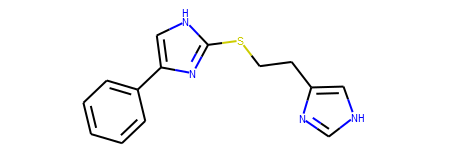

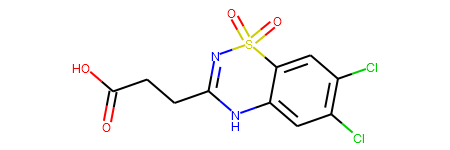

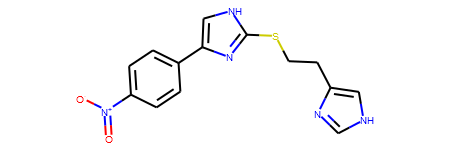

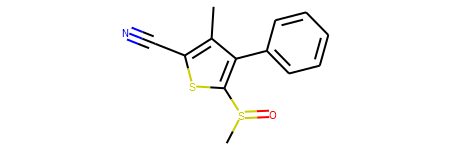

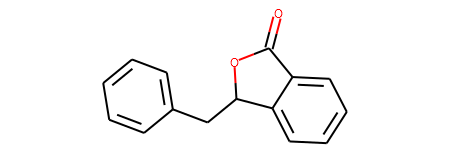

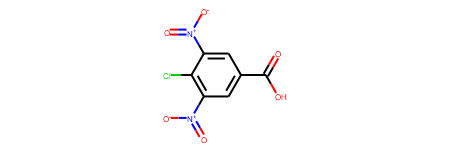

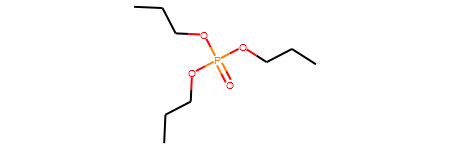

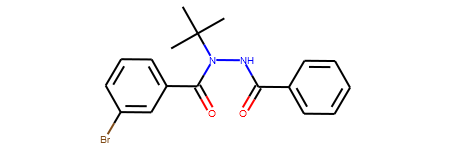

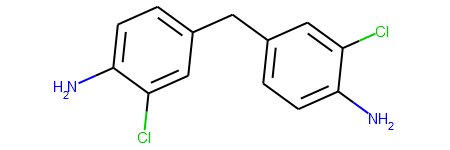

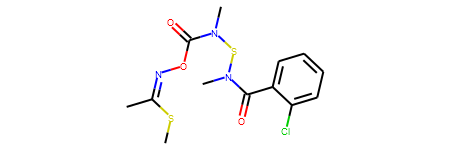

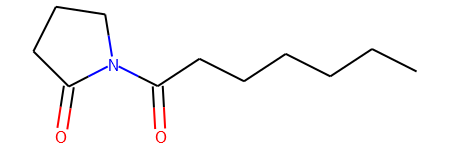

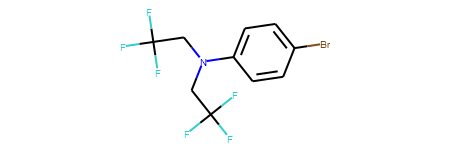

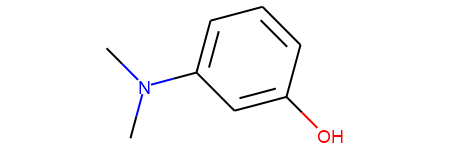

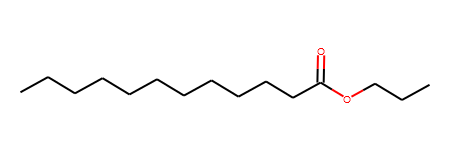

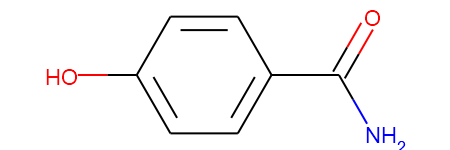

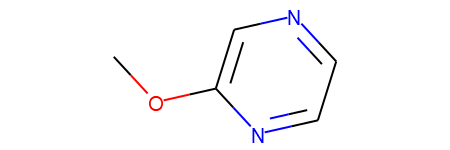

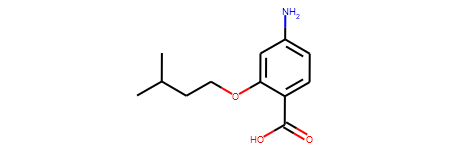

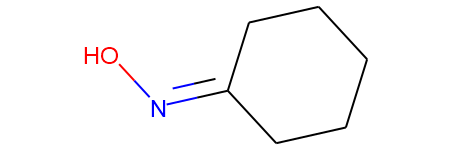

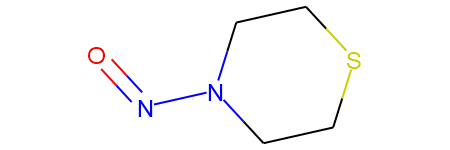

In [92]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [93]:
worst = data[2].reset_index().drop(columns=['index'])

In [94]:
indices = pd.Series(np.random.randint(631, size=20))

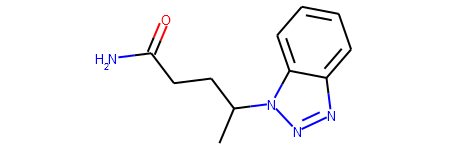

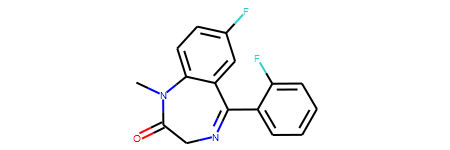

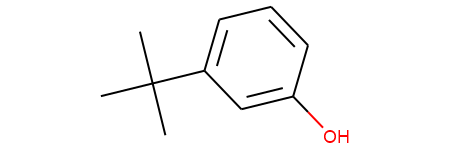

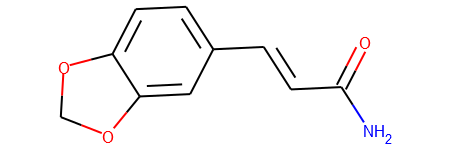

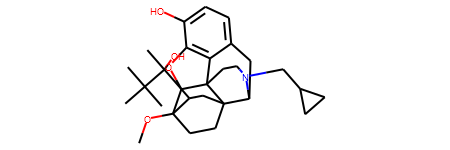

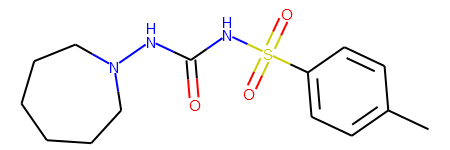

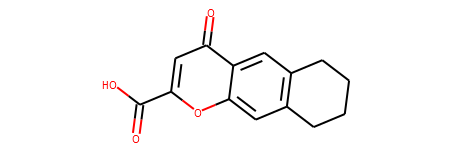

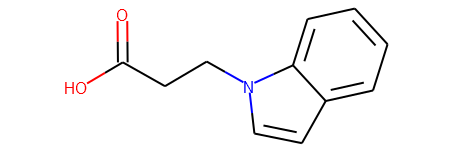

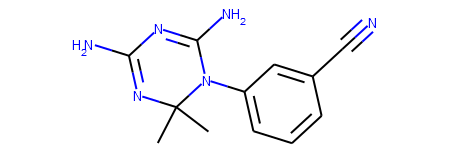

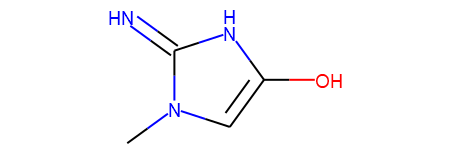

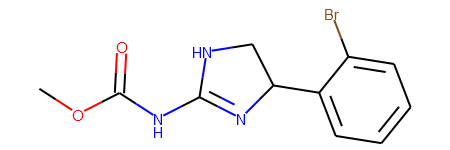

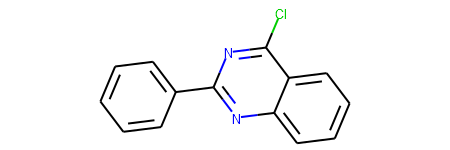

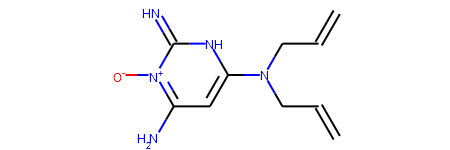

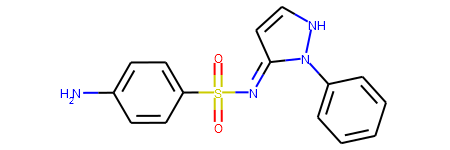

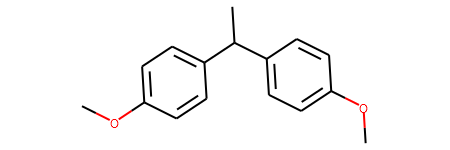

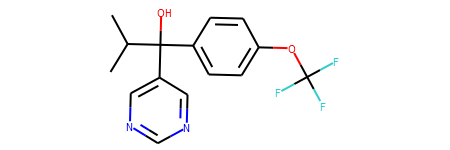

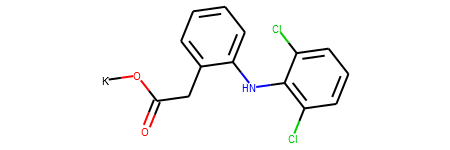

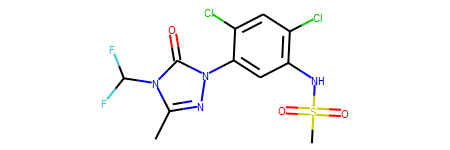

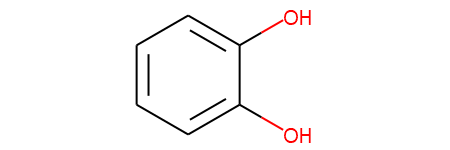

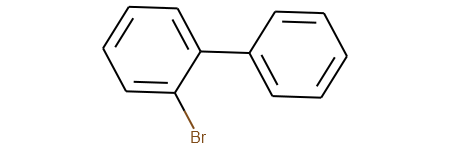

In [95]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [20]:
n_values = 50

In [21]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [22]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [23]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
768,CCCCC(C)(C)c1ccc(C2CCCC(O)C2)c(O)c1,5.43,5.430184,3.370080e-08,7,0,1,14.285714,0,0.0
107,C1CCOC1,0.46,0.460265,7.017615e-08,16,1,3,18.750000,1,100.0
811,CCOC(CP(=O)(OCC)OCC)OCC,0.69,0.689519,2.310887e-07,14,1,0,0.000000,1,100.0
1249,C=COCCn1cnc2[nH]c(=O)n(C)c(=N)c21,-0.78,-0.779291,5.022452e-07,12,1,0,0.000000,0,0.0
1743,COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl,4.59,4.589188,6.586371e-07,13,1,3,23.076923,1,100.0


In [24]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
147,CC(C)(C)c1cc(CCC(=O)OCC(COC(=O)CCc2cc(C(C)(C)C...,1.36,14.621465,175.866454,17,2,4,23.529412,2,100.000000
1015,CCc1c(C(=O)O)c(=O)cnn1-c1ccc(Cl)cc1,-2.20,2.722881,24.234753,19,3,1,5.263158,1,33.333333
1642,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,9.720734,17.814596,17,1,0,0.000000,1,100.000000
79,O=C(Cc1ccccc1Nc1c(Cl)cccc1Cl)O[K],0.65,4.317653,13.451680,11,1,0,0.000000,0,0.000000
1087,CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1,5.50,2.964316,6.429692,9,2,0,0.000000,1,50.000000


In [25]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
count,50.000000,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.877000,1.876984,2.968691e-05,15.100000,1.460000,1.000000,6.819897,0.720000,51.333333
std,2.094566,2.094761,2.942331e-05,6.565992,0.994064,1.142857,8.383030,0.671277,46.515791
min,-2.190000,-2.192489,3.370080e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.665000,0.670033,2.007822e-06,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.570000,1.568205,2.347664e-05,14.000000,1.000000,1.000000,5.488722,1.000000,50.000000
75%,2.780000,2.773160,5.049591e-05,17.000000,2.000000,2.000000,10.394737,1.000000,100.000000
max,8.010000,8.011377,1.002655e-04,35.000000,4.000000,4.000000,40.000000,2.000000,100.000000


In [26]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.815400,2.537446,6.861612,16.460000,1.680000,0.800000,4.770998,1.120000,65.333333
std,2.003186,2.627733,24.731140,6.640045,0.957036,1.212183,7.604364,0.824126,40.243026
min,-3.170000,-1.658336,1.583021,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.745000,1.010331,1.813422,12.000000,1.000000,0.000000,0.000000,1.000000,37.500000
50%,1.760000,2.270194,2.318370,16.000000,2.000000,0.000000,0.000000,1.000000,100.000000
75%,2.815000,3.392830,3.041490,19.000000,2.000000,1.000000,7.598499,1.750000,100.000000
max,6.080000,14.621465,175.866454,41.000000,4.000000,4.000000,36.363636,4.000000,100.000000


### Check atom_count influence

In [27]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-1.0298158448900483, pvalue=0.3056314112066335)


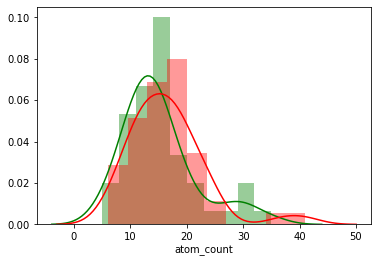

In [28]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [29]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-1.1273659175757744, pvalue=0.262340516659739)


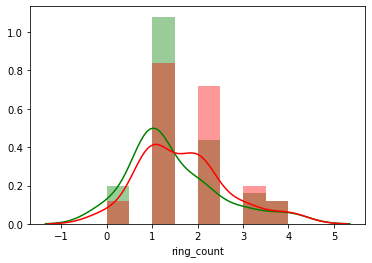

In [30]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [31]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=0.8488746876271652, pvalue=0.39801982407062386)


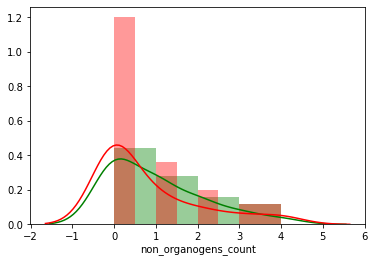

In [32]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [33]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=1.2800538795431278, pvalue=0.20354797107880618)


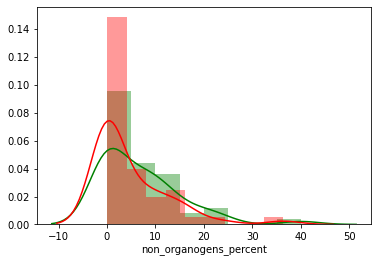

In [34]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [35]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=-2.66100072444397, pvalue=0.009104496890718919)


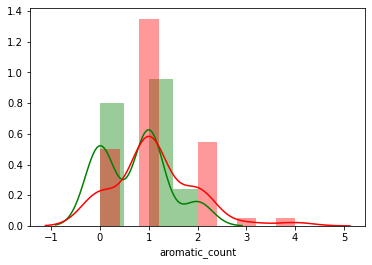

In [36]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [37]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=-1.609467613393167, pvalue=0.11073084457767088)


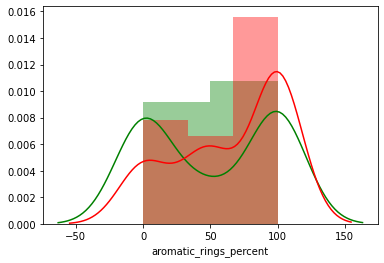

In [38]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')